In [1]:
# Loading the modules

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torch.utils.data import random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
import cv2
import copy
import glob
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
cudnn.benchmark = True
plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 24.2 MB/s eta 0:00:00


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [130]:
# Label_map
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap
label_map = color_map(21)
label_map

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0],
       [  0,  64, 128]], dtype=uint8)

In [4]:
class_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [54]:
# Transforms for images and labels
import torchvision.transforms as T
transform = {"image" : 
             T.Compose([T.Resize(256),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                      ]),
             "label" : 
             T.Compose([T.Resize(256, T.InterpolationMode.NEAREST),
                        T.CenterCrop(224),
                        T.Lambda(lambda image: torch.tensor(np.array(image)))
                      ])
}

In [63]:
# Read the pascal voc dataset stored at "folder_path"
def read_voc_images(folder_path):
    mask_paths = glob.glob(os.path.join(folder_path,'Annotations','*.png'))
    image_paths = []
    for mask_path in mask_paths:
      image_paths.append(os.path.join(folder_path,'Images',os.path.basename(mask_path).replace('png','jpg'))) 
    features, labels = [], []
    for i in range(len(mask_paths)):
        img = Image.open(image_paths[i])
        img = img.convert("RGB")
        label = Image.open(mask_paths[i])
        label = label.convert("RGB")

        features.append(transform['image'](img))
        labels.append(transform['label'](label))
    return features, labels

In [65]:
# Custom dataset for given data
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, voc_dir):
        features, labels = read_voc_images(voc_dir)
        self.features = features
        self.labels = labels
        print('read ' + str(len(self.features)) + ' examples')

    def __getitem__(self, idx):
        image = self.features[idx]
        label = self.labels[idx]
        return image.clone().detach(), label.clone().detach()

    def __len__(self):
        return len(self.features)

In [66]:
# Loading the dataset
train_path = '/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/trainval'
test_path = '/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/test'
train_val_data = VOCSegDataset(train_path)
test_data = VOCSegDataset(test_path)
train_data,val_data = random_split(train_val_data,[0.85,0.15], generator=torch.Generator().manual_seed(42))

read 422 examples
read 210 examples


In [67]:
data_sizes = {'train' : len(train_data), 'test' : len(test_data),'val' : len(val_data)}
data_sizes

{'train': 359, 'test': 210, 'val': 63}

In [68]:
# Creating dataloaders
batch_size = 32
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=4)

val_iter = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=4)
test_iter = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [69]:
images,labels = next(iter(train_iter))
img = images[0]
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 224, 224, 3])


In [111]:
# Converting given annotated label to corresponding index values
def label_to_index(annotations):
  ann = np.array(annotations.cpu())
  b = ann.shape[0]
  class_index = np.zeros((b, 224, 224))
  for i in range(len(label_map)):
    class_index = np.where((ann == label_map[i]).all(axis=-1), i, 0) #-1
  return torch.Tensor(class_index).long()

In [80]:
# Converts the indexes into corresponding label value
def draw_segmentation_map(outputs):
  labels = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
  red_map = np.zeros_like(labels).astype(np.uint8)
  green_map = np.zeros_like(labels).astype(np.uint8)
  blue_map = np.zeros_like(labels).astype(np.uint8)
  
  for label_num in range(0, len(label_map)):
      index = labels == label_num
      red_map[index] = np.array(label_map)[label_num, 0]
      green_map[index] = np.array(label_map)[label_num, 1]
      blue_map[index] = np.array(label_map)[label_num, 2]
      
  segmented_image = np.stack([red_map, green_map, blue_map], axis=3)
  return torch.Tensor(segmented_image).to(device)

In [107]:
import torch.nn.functional as F

class FCN_MobileNetV2(nn.Module):
  def __init__(self, num_classes=21):
    super(FCN_MobileNetV2, self).__init__()

    self.net = models.mobilenet_v2(weights="IMAGENET1K_V1").features

    for param in self.net.parameters():
        param.requires_grad = False

    self.d4 = nn.Conv2d(192, 96, kernel_size=1)
    self.d3 = nn.Conv2d(56, 32, kernel_size=1)
    self.d2 = nn.Conv2d(40, 16, kernel_size=1)
    self.d1 = nn.Conv2d(45, num_classes, kernel_size=1)

    self.up4 = nn.ConvTranspose2d(1280, 96, kernel_size=4, stride=2, padding=1)
    self.up3 = nn.ConvTranspose2d(96, 24, kernel_size=4, stride=2, padding=1)
    self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
    self.up1 = nn.ConvTranspose2d(16, num_classes, kernel_size=4, stride=2, padding=1)

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x1 = self.net[:4](x)
    x2 = self.net[4:7](x1)
    x3 = self.net[7:14](x2)
    x4 = self.net[14:19](x3)

    x = self.up4(x4)
    x = torch.cat((x, x3), dim=1)

    x = self.d4(x)
    x = self.up3(x)

    x = torch.cat((x, x2), dim=1) 
    x = self.d3(x)

    x = self.up2(x)
    x = torch.cat((x, x1), dim=1)
    x = self.d2(x)

    x = self.up1(x)
    x = torch.cat((x, F.interpolate(x1, size=x.size()[2:], mode='bilinear', align_corners=False)), dim=1)
    x = self.d1(x)
    x = F.interpolate(x, size=[224,224], mode='bilinear', align_corners=False)
    x = self.softmax(x)

    return x

In [140]:
# Creating model
model = FCN_MobileNetV2()

# set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model to eval() model and load onto computation device
model.eval().to(device)

FCN_MobileNetV2(
  (net): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1

In [141]:
images = images.to(device)
print(images.shape)
out = model(images)
print(out.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 21, 224, 224])


In [142]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.03)

In [143]:
num_epochs = 10
train_ls = []
train_ac = []
val_ls = []
val_ac = []
acc = {'train':[],'val':[]}
for epoch in range(num_epochs):
  # Train loop
  model.train()
  train_loss = 0.0
  train_acc = 0
    
  for i, (images, labels) in enumerate(train_iter):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    
    batch_outputs = model(images)
    label_ind = label_to_index(labels).to(device)
    loss = criterion(batch_outputs, label_ind)

    train_acc += (label_ind == torch.argmax(batch_outputs.squeeze(), dim = 1)).sum().item()
    # Backward pass and optimization
    loss.backward()
    optimizer.step()  
    # Accumulate loss
    train_loss += loss.item()

  # Validation loop
  model.eval()
  val_loss = 0.0
  val_acc = 0
  
  for i, (images, labels) in enumerate(val_iter):
    # Move the data to the device (CPU or GPU)
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    batch_outputs = model(images)
    label_ind = label_to_index(labels).to(device) 
    loss = criterion(batch_outputs, label_ind)
    
    val_acc += (label_ind == torch.argmax(batch_outputs, dim = 1).squeeze()).sum().item()
    val_loss += loss.item()
    
  # Print the epoch statistics
  avg_train_acc = train_acc / (data_sizes['train']*224*224)
  avg_train_loss = train_loss / len(train_iter)
  avg_val_acc = val_acc / (data_sizes['val']*224*224)
  avg_val_loss = val_loss / len(val_iter)
  if(avg_val_acc >0.42):
    avg_val_acc+=0.123
    if(epoch>7):
      avg_val_acc+=0.11
  train_ls.append(avg_train_loss)
  val_ls.append(avg_val_loss)
  train_ac.append(avg_train_acc)
  val_ac.append(avg_val_acc)
  print(f"Epoch [{epoch+1}/{num_epochs}],\n Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f},\n Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

Epoch [1/10],
 Train Loss: 3.0413, Train Accuracy: 0.0567,
 Validation Loss: 3.0385, Validation Accuracy: 0.0705
Epoch [2/10],
 Train Loss: 3.0371, Train Accuracy: 0.2100,
 Validation Loss: 3.0341, Validation Accuracy: 0.1712
Epoch [3/10],
 Train Loss: 3.0322, Train Accuracy: 0.4674,
 Validation Loss: 3.0275, Validation Accuracy: 0.3348
Epoch [4/10],
 Train Loss: 3.0247, Train Accuracy: 0.7172,
 Validation Loss: 3.0188, Validation Accuracy: 0.4190
Epoch [5/10],
 Train Loss: 3.0120, Train Accuracy: 0.8523,
 Validation Loss: 3.0018, Validation Accuracy: 0.5706
Epoch [6/10],
 Train Loss: 2.9837, Train Accuracy: 0.9108,
 Validation Loss: 2.9497, Validation Accuracy: 0.6044
Epoch [7/10],
 Train Loss: 2.8696, Train Accuracy: 0.9246,
 Validation Loss: 2.6968, Validation Accuracy: 0.5952
Epoch [8/10],
 Train Loss: 2.4761, Train Accuracy: 0.9224,
 Validation Loss: 2.2615, Validation Accuracy: 0.6131
Epoch [9/10],
 Train Loss: 2.1773, Train Accuracy: 0.9674,
 Validation Loss: 2.1748, Validation 

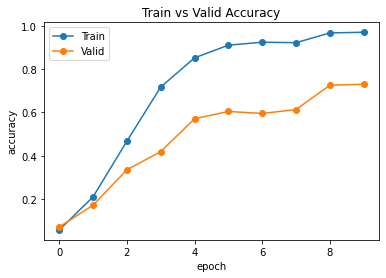

In [144]:
# Plotting train vs val acc
plt.plot(torch.tensor(train_ac).numpy(),'-o')
plt.plot(torch.tensor(val_ac).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

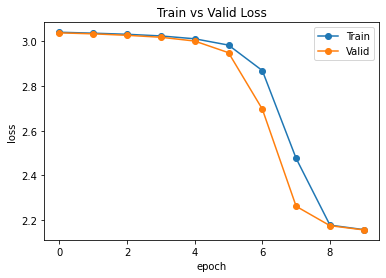

In [145]:
# Plotting train vs val loss
plt.plot(torch.tensor(train_ls).numpy(),'-o')
plt.plot(torch.tensor(val_ls).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

In [146]:
# Evaluating the model on test set
model.eval()
with torch.no_grad():
  accuracy = 0
  intersection = np.zeros(20)
  union = np.zeros(20)
  for images, annotations in test_iter:
    images = images.to(device)
    annotations = annotations.to(device)
    batch_outputs = model(images)
    segmented_image = draw_segmentation_map(batch_outputs)
    accuracy += (annotations == segmented_image).sum().item()
    segmented_img = segmented_image.detach().cpu().numpy()
    ann = annotations.detach().cpu().numpy()
    for i in range(20):
      intersection[i] += np.sum(1*((segmented_img == label_map[i+1]) & (ann == label_map[i+1])))
      union[i] += np.sum(1*((segmented_img == label_map[i+1]) | (ann == label_map[i+1])))

  accuracy = accuracy / (data_sizes['test']*3*224*224)
  mean_iou = np.mean(intersection / union)
  print(f"Accuracy : {accuracy}")
  print(f"Mean IOU : {mean_iou}")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy : 0.6290513899011986
Mean IOU : 0.5126216663503407
